### 교차검증(cross validation)

* 검증 데이터: 훈련데이터에서 모델을 검증하기 위해 떼어 놓는 데이터
    * 실전에서 테스트는 모델을 성능 평가에 사용할 수 없기 때문에
* 교차 검증: 데이터가 적을 때 모델을 그나마(?) 안정적으로 평가할 수 있는 방법
    * 훈련 데이터로 모델을 학습 시키고
    * 검증 데이터로 모델을 평가
    * 모델의 최종 평가는 검증 데이터의 평균으로!
        | | | |
        |---|---|---|
        |훈련 데이터|훈련 데이터|**검증 데이터**|
        |훈련 데이터|**검증 데이터**|훈련 데이터|
        |**검증 데이터**|훈련 데이터|훈련 데이터|

* $k$-fold cross validation: 훈련 데이터를 $k$등분 하여 교차 검증하는 방법
    * $k$가 5(20%) 혹은 10(10%)일때를 많이 사용
    
**주의! `cross_validate()`는 훈련 데이터를 섞어주지는 않는다!**

**따라서 분류 모델을 만들 때는 `cv=StratifiedKFold()`를 지정해 주는 것이 좋다.**

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline

matplotlib_inline.backend_inline.set_matplotlib_formats("png2x") # svg, retina, png2x ...
mpl.style.use("seaborn-v0_8")
mpl.rcParams.update({"figure.constrained_layout.use": True})
sns.set_context("paper") 
sns.set_palette("Set2") 
sns.set_style("whitegrid") 

# 시스템 폰트패밀리에 따라 변경
plt.rc("font", family = "NanumSquareRound")
plt.rcParams["axes.unicode_minus"] = False

In [5]:
heart = pd.read_csv("../../data/heart.csv")

X = heart[[i for i in heart.columns if i != "thall"]]
y = heart["thall"]

In [6]:
from sklearn.model_selection import train_test_split


x_train, x_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.20,
                                                    random_state = 42)

In [7]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

model = DecisionTreeClassifier(max_depth = 5, random_state=42) 

In [8]:
# test_score를 혼동하지 마세요!
score = cross_validate(estimator = model,
                       X = x_train, 
                       y = y_train, 
                       cv = 3)
score

/home/tommy/miniconda3/envs/p311/lib/python3.11/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


{'fit_time': array([0.00308299, 0.00213647, 0.00197101]),
 'score_time': array([0.00151181, 0.00125289, 0.00129175]),
 'test_score': array([0.67901235, 0.65432099, 0.675     ])}

In [9]:
# 5-fold cross validation의 결과
np.mean(score["test_score"])
#cross_val_score(model, x_train, y_train, cv = 5)

np.float64(0.6694444444444446)

In [10]:
# 주의! `cross_validate()`는 훈련 데이터를 섞어주지는 않는다!
# 따라서 분류 모델을 만들 때는 `cv=StratifiedKFold()`를 지정해 주는 것이 좋다.

score_strat = cross_validate(estimator = model, 
                             X = x_train, 
                             y = y_train, 
                             cv = StratifiedKFold())
np.mean(score_strat["test_score"])
score_strat

/home/tommy/miniconda3/envs/p311/lib/python3.11/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


{'fit_time': array([0.00253725, 0.00236917, 0.00219345, 0.00162268, 0.00153685]),
 'score_time': array([0.00137305, 0.00128984, 0.001055  , 0.00081205, 0.00094199]),
 'test_score': array([0.67346939, 0.71428571, 0.625     , 0.64583333, 0.64583333])}

In [11]:
splitter = StratifiedKFold(n_splits = 10, shuffle=True, random_state = 42)

score_strat_split = cross_validate(estimator = model, 
                             X = x_train, 
                             y = y_train, 
                             cv = splitter)

score_strat_split

/home/tommy/miniconda3/envs/p311/lib/python3.11/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


{'fit_time': array([0.00256395, 0.00235868, 0.00193572, 0.00172138, 0.00189614,
        0.00162363, 0.00153446, 0.00153255, 0.00154305, 0.00152922]),
 'score_time': array([0.00128531, 0.00116968, 0.00090861, 0.00079656, 0.00105381,
        0.00099659, 0.00082564, 0.00088954, 0.00085449, 0.0007627 ]),
 'test_score': array([0.6       , 0.72      , 0.66666667, 0.70833333, 0.70833333,
        0.41666667, 0.75      , 0.70833333, 0.66666667, 0.625     ])}

### 그리드 서치(Grid Search)

* 모델 파라미터(일반적으로 말하는 파라미터를 의미): 모델이 학습 하면서 변화하게 되는 값. 딥러닝 모델의 경우 가중치가 파라미터

* 하이퍼 파라미터(매개변수): 모델의 학습 전에 설정해 주는 값. 아무런 설정도 하지 않으면 기본값(`default`)로 학습하게 됨

In [12]:
# max_depth = 3
model = DecisionTreeClassifier(max_depth = 3, random_state=209) 
model.fit(x_train.values, y_train.values)
prediction = model.predict(x_test.values)
print('The accuracy of the DT is', 
      accuracy_score(prediction, y_test))

The accuracy of the DT is 0.639344262295082


* GridSearchCV는 k-fold cross validation도 해준다!
* 아래의 코드의 경우 params의 변수가 4개이고, cv가 3이므로 params의 변수 하나 마다 3번의 결과를 내놓는다. 즉, 12번의 학습을 하게 된다. 
* 따라서 그리드서치를 할 때에는 `n_jobs = -1`(모든 코어 사용)로 하는 것이 좋다.

In [13]:
params = {"max_depth" : [3, 4, 5, 10]}

model_base = DecisionTreeClassifier(random_state=209) 
model_grid = GridSearchCV(model_base, 
                          params, 
                          cv=3, 
                          return_train_score=True,
                          #n_jobs = -1
                         )
model_grid.fit(x_train, y_train)

/home/tommy/miniconda3/envs/p311/lib/python3.11/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=209),
             param_grid={'max_depth': [3, 4, 5, 10]}, return_train_score=True)

In [14]:
# 가장 결과가 좋은 매개변수(하이퍼 파라미터)
model_grid.best_params_

{'max_depth': 3}

In [15]:
# 훈련데이터 중 가장 좋은 정확도
model_grid.best_score_

np.float64(0.7025205761316872)

In [16]:
# 가장 결과가 좋은 매개변수로 테스트 데이터를 예측해 보자
model_best = model_grid.best_estimator_
model_best.predict(x_test)

array([3, 3, 3, 3, 2, 3, 2, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 3, 3, 3, 3, 3,
       3, 2, 2, 2, 2, 2, 3, 2, 3, 3, 3, 2, 2, 3, 2, 2, 2, 2, 3, 3, 3, 2,
       2, 2, 3, 3, 3, 3, 2, 2, 2, 2, 2, 3, 3, 2, 3, 3, 3])

In [17]:
## model_best의 테스트 데이터에 대한 정확도를 계산하시오.
pred_best = model_best.predict(x_test)
accuracy_score(pred_best, y_test)

0.639344262295082

In [18]:
def grid_search(params, model_base=DecisionTreeClassifier(random_state=209)):
    model_grid = GridSearchCV(model_base, 
                              params, 
                              cv=3, 
                              return_train_score=True,
                              #n_jobs = -1
                             )
    model_grid.fit(x_train, y_train)
    
    print('최상의 매개변수: ', model_grid.best_params_)
    print('훈련 데이터의 최고 정확도: ', model_grid.best_score_)
    
    model_best = model_grid.best_estimator_
    pred_best = model_best.predict(x_test)
    print('테스트 데이터의 최고 정확도: ', accuracy_score(pred_best, y_test))

In [19]:
grid_search(params = {"min_samples_leaf": [1,2,4,8],
                     "max_depth" : [3, 4, 5, 10],
                      "criterion": ["gini", "entropy"]})

/home/tommy/miniconda3/envs/p311/lib/python3.11/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


최상의 매개변수:  {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 1}
훈련 데이터의 최고 정확도:  0.7108539094650205
테스트 데이터의 최고 정확도:  0.639344262295082


/home/tommy/miniconda3/envs/p311/lib/python3.11/site-packages/numpy/ma/core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


**Quiz.** 지금 조건에서 GridSearchCV는 몇 번 실험을 할까?

**주의! min_samples_leaf에서 제일 좋은 결과를 내는 하이퍼 파라미터를 찾고, 그 다음으로 max_depth에서 제일 좋은 결과를 내는 하이퍼 파라미터를 찾는 것이 아니다!**

# 3. RandomizedSearchCV

* GridSearchCV로 하이퍼 파라미터를 튜닝하면 모든 조합에 대해서 테스트 하기 때문에 시간이 너무 오래걸린다는 단점이 있다. 
* 이를 보완하기 위해 RandomizedSearchCV를 사용할 수 있다. 
* RandomizedSearchCV의 작동방식은 GridSearchCV와 같지만 하이퍼 파라미터를 랜덤하게 조합하여 테스트 한다. 따라서 지정한 조합의 횟수 안에서 최상이 조합을 찾는다

* 실수 난수 생성: [np.random.uniform](https://numpy.org/doc/stable/reference/random/generated/numpy.random.uniform.html)

* 정수 난수 생성: [np.ramdom.randint](https://numpy.org/doc/stable/reference/random/generated/numpy.random.randint.html)

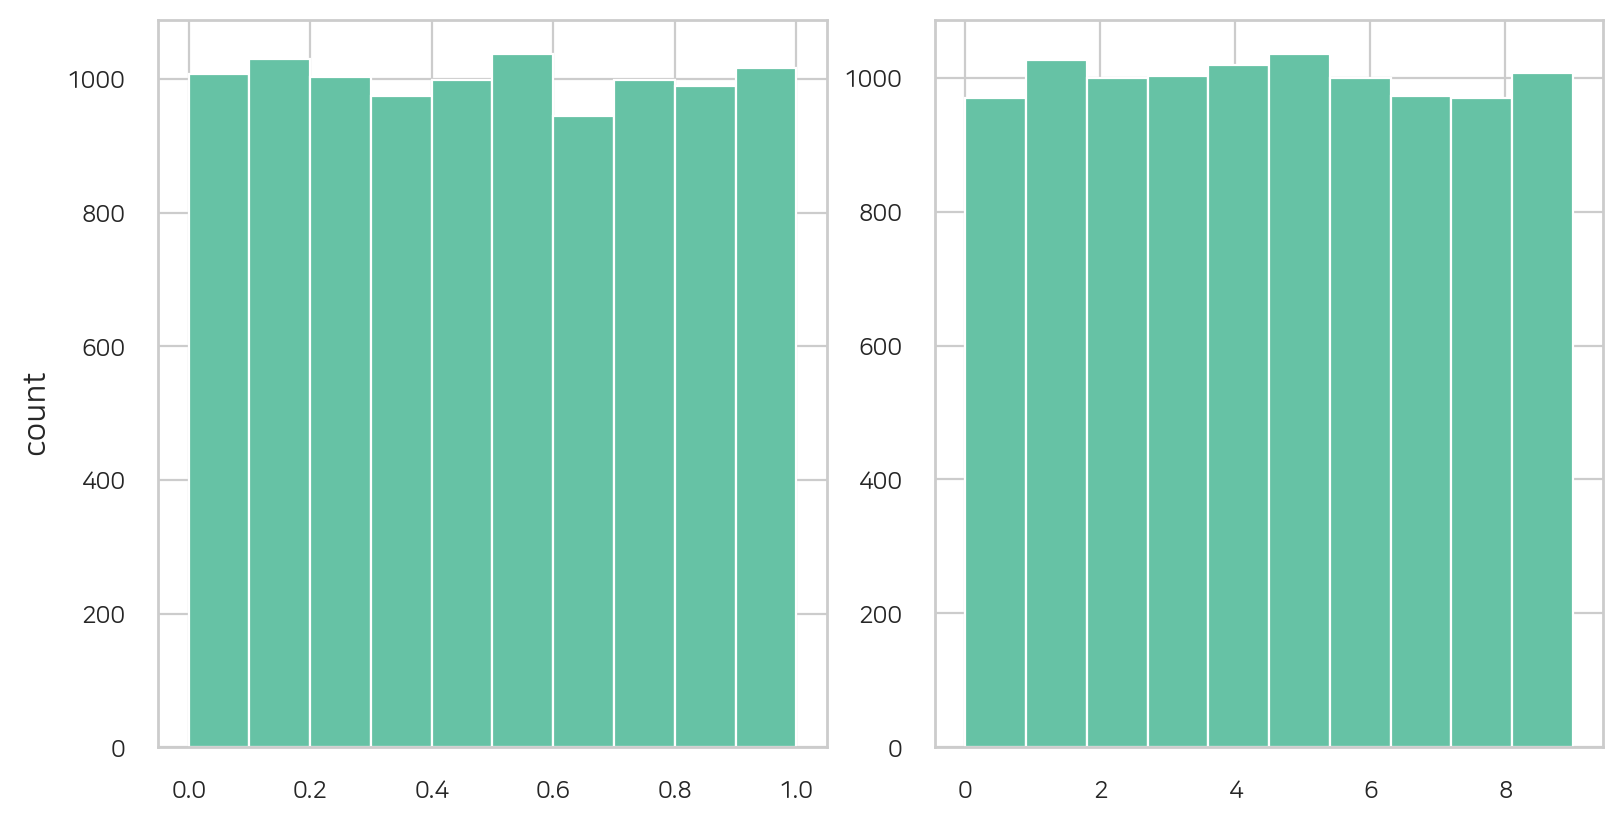

In [20]:
fig, (ax_uni, ax_int) = plt.subplots(1, 2, figsize = (8,4))

size = 10_000
bins = 10

ax_uni.hist(np.random.uniform(0, 1, size), bins = bins)
ax_int.hist(np.random.randint(0, 10, size), bins = bins)
fig.supylabel("count");

In [21]:
from sklearn.model_selection import RandomizedSearchCV

In [22]:
def random_grid_search(params, iters, model_base=DecisionTreeClassifier(random_state=209)):
    model_grid = RandomizedSearchCV(model_base, 
                                    params,
                                    n_iter = iters,
                                    cv=3, 
                                    return_train_score=True,
                                    #n_jobs = -1,
                                    random_state = 97
                                    )
    model_grid.fit(x_train, y_train)
    
    print('최상의 매개변수: ', model_grid.best_params_)
    print('훈련 데이터의 최고 정확도: ', model_grid.best_score_)
    
    model_best = model_grid.best_estimator_
    pred_best = model_best.predict(x_test)
    print('테스트 데이터의 최고 정확도: ', accuracy_score(pred_best, y_test))

In [23]:
params = {"criterion": ["entropy", "gini"],
          "min_samples_leaf": np.random.randint(1, 10, 10),
          "max_depth" : np.random.randint(3, 8, 20),
          "min_impurity_decrease": np.random.uniform(0.001, 0.01, 30)}

In [24]:
random_grid_search(params, 50, model_base)

/home/tommy/miniconda3/envs/p311/lib/python3.11/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


최상의 매개변수:  {'min_samples_leaf': np.int64(1), 'min_impurity_decrease': np.float64(0.0025801967067533025), 'max_depth': np.int64(3), 'criterion': 'entropy'}
훈련 데이터의 최고 정확도:  0.7108539094650205
테스트 데이터의 최고 정확도:  0.639344262295082
